## OpenSubtitles corpus 
The following code was used to extract Polish OpenSubtitles corpus.
It consists of ~775 milion tokens and ~143 milion sentences, vastly dialogues which makes it best suited for human to machine interface applications.

It is build using a data from Open Parallel Corpis: http://opus.lingfil.uu.se/OpenSubtitles2016.php 

**IMPORTANT**: If you use the OpenSubtitle corpus: 
Please, add a link to http://www.opensubtitles.org/ to your website and to your reports and publications produced with the data! 

You need at least 30GB of free storage to process the data.

The firs step it to prepare a data folder.

In [7]:
%%bash
mkdir -p data
truncatefile > data/OpenSubtitles2016.txt 2&> /dev/null
echo "Truncated data/OpenSubtitles2016.txt"

Truncated data/OpenSubtitles2016.txt


Next step is to download the data.

In [23]:
import codecs
import lxml.etree as etree
import os
import regex
from tqdm import tqdm
from urllib.request import urlretrieve
import subprocess

class DLProgress(tqdm):
    """ A class to display progressbar..."""
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def download_dump(arch_uri="http://opus.lingfil.uu.se/download.php?f=OpenSubtitles2016/", 
                  file="pl.tar.gz"):
    """Download archive file"""
    datafile=os.path.join("data", file)
    if not (os.path.isfile(datafile) or os.path.isfile(datafile[:-4])):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=file) as pbar:
            urlretrieve(arch_uri+file, datafile, pbar.hook)
    print ("Downloading DONE")
 
    return datafile

def extract(filepath):
    """extract using subprocess"""
    bashCommand = ["tar",'-xvf', filepath, '-C','data']
    try:
        output = subprocess.check_output(bashCommand, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as pserror: 
        print (pserror.output)
    else:
        print ("DONE {}".format(output))


In [24]:
subtitles=download_dump(arch_uri="http://opus.lingfil.uu.se/download.php?f=OpenSubtitles2016/", file="pl.tar.gz")
extract(subtitles)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Cleaning up the data

When I initially parsed the data and build a word2vec out of it I realized that each and every common word has a number of transcription variants in the vocabulary. Some were typos but most were due to improper character encoding. The letter ą was encoded as š or ŕ, the letter ć as č, æ or ă, letter ę as ê or ć etc..

I analyzed it further and found that about 1000 files contained improperly encoded characters. I plotted the histogram of number of improperly encoded tokens in the file.

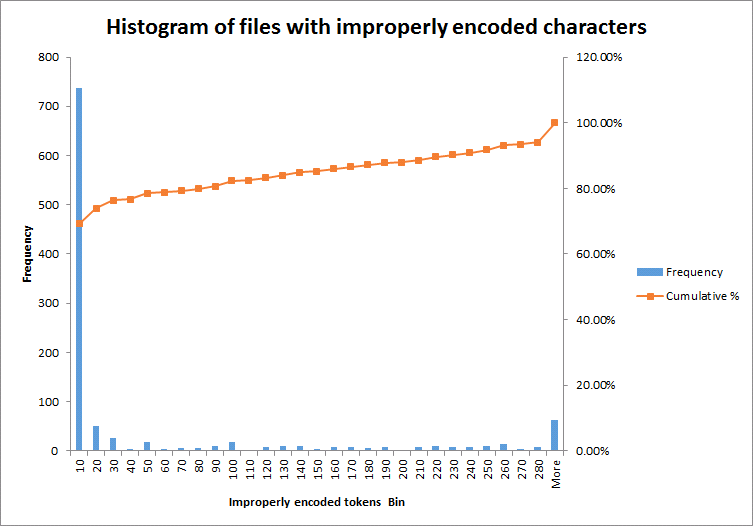

Files with las than 20 improperly encoded tokens are probably containing a foreign name from some other language like "Siniškievicia", "Siniša", "Pašić", "Miško", "Blatište", "Tidža" etc. or a single typo with no influence on the whole corpus. 

Files with 20 to 30 improperly encoded tokens are probably having mixed encoding, like having dialogues in multiple languages or composed of two translations each encoded in different encoding.

Files with more than 50 to 80 tokens containign foreing characters are improperly encoded in total. 

A solution to that is to completely discard the files with more than 20 of improperly encoded tokens. It's 278 files, less than 0.07% of all files and over 56000 improperly encoded tokens.

In [31]:
%%bash
echo "Removing improperly encoded files"
while read i; do
  rm -f $i
done < OpenSubtitle-discard-files.txt

Removing improperly encoded files


## Buildign corpus file

The following code builds txt corpus file. In the target file each line is a new sentence with tokens separated by spaces. The basic punctuation is retained. 

In [32]:
%%time

from io import StringIO, BytesIO
def build_OpenSubtitlesCorpus(filepath, txt_file="data/OpenSubtitles2016.txt"):
    with codecs.open(txt_file, 'a', 'utf-8') as fout:
        """
        Extract txt corpus from xml files
        """
        # parse XML
        tree= etree.parse(filepath)
        s= ((etree.tostring(tree.getroot()) ))
        s=BytesIO(s)

        doc=[]
        sent=[]
        """Iterate over xml word and sentence tags and build text corpus"""
        for action, elem in etree.iterparse(s, tag=['w','s']):
            
            # append all words in sentence
            if elem.text is not None and elem.text!="":
                sent.append(elem.text)
                
            # when the sentence is finished
            if (action=='end' and elem.tag=='s'):
                if sent:
                    doc.append(" ".join(sent))
                sent=[]

        doc="".join(doc)
        doc = regex.sub(u"[^ \n\p{Latin}\-'‘’.?!]", " ", doc) # clean text
        doc = regex.sub(u" - ", " ", doc) # Dialog hypens
        doc = regex.sub(u" *\n *", "\n", doc) # Squeeze spaces
        doc = regex.sub(u" +", " ", doc) # Squeeze spaces        

        # wrote to file
        fout.write(doc.lower()+"\n")

                
#build_OpenSubtitlesCorpus("data/OpenSubtitles2016/xml/pl/1998/568102/3380400.xml.gz", txt_file="OS-test.txt")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.4 µs


In [33]:
%%time
for root, subdirs, files in (os.walk("data/OpenSubtitles2016/xml/pl")):
    for filename in (files):
        file_path = os.path.join(root, filename)
        build_OpenSubtitlesCorpus(file_path)
        
print ("DONE")

DONE
CPU times: user 1h 10min 44s, sys: 16.6 s, total: 1h 11min
Wall time: 1h 11min 12s
